In [ ]:
# Name: Arooba Hanif
# Roll Number: Ezi-ML-B1-227
# Shift Time: Remote
# Internship Type: Hybird/Remote

# TASK 10

In [ ]:
# Cell 0: Install dependencies
# NOTE: After this cell completes we'll MUST restart the runtime (Colab: Runtime -> Restart runtime).

# upgrade pip
!pip install --upgrade pip --quiet

# install compatible numpy and nibabel + basic libs
!pip install --quiet "numpy==1.26.4" "nibabel==3.2.2" "scikit-image" "opencv-python" "simpleitk" "tqdm"

# TensorFlow (install latest stable; if Colab already has TF, this will be quick)
!pip install --quiet "tensorflow>=2.16"

# sklearn, matplotlib, seaborn
!pip install --quiet scikit-learn matplotlib seaborn

# Kaggle CLI (only if you will use Kaggle mirror)
!pip install --quiet kaggle

# optional: gradio for small demo UI (install if you want)
!pip install --quiet gradio


In [ ]:
# Cell 1: check versions to ensure compatibility
import sys, os
import numpy as np
print("Python:", sys.version.splitlines()[0])
print("NumPy:", np.__version__)
try:
    import nibabel as nib
    print("nibabel:", nib.__version__)
except Exception as e:
    print("nibabel import ERROR:", e)
import tensorflow as tf
print("TensorFlow:", tf.__version__)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
NumPy: 1.26.4
nibabel: 3.2.2
TensorFlow: 2.19.0


In [ ]:
# STEP: Get your kaggle API token (kaggle.json) from Kaggle -> Account -> API.
kaggle_username = "YOUR_KAGGLE_USERNAME"
kaggle_key = "YOUR_KAGGLE_KEY"

import json, os
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# Download a common BraTS Kaggle mirror
# Example: awsaf49/brats20-dataset-training-validation
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 98% 4.09G/4.16G [01:18<00:03, 25.2MB/s]
100% 4.16G/4.16G [01:18<00:00, 57.0MB/s]


In [ ]:
# Cell 3: Inspect dataset folder and list example subject folders
import os, glob, pprint

# update path depending on which option you used:
root = "/content"   # Kaggle unzip goes to /content by default
# or for demo: root = "/content/niivue_samples/niivue-images-main"

# Search folders that look like BraTS subjects (contain flair/t1/t2/t1ce/seg files)
candidates = []
for d in glob.glob(os.path.join(root, "**"), recursive=True):
    files = glob.glob(os.path.join(d, "*flair*.nii*")) + glob.glob(os.path.join(d, "*t1*.nii*"))
    if files:
        candidates.append(d)

print("Found candidate folders (first 20):")
pprint.pprint(candidates[:20])


Found candidate folders (first 20):
['/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_052',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_014',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_317',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_006',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_199',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_258',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_011',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_290',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_284',
 '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_263',
 '/cont

In [ ]:
# Cell 4: Helpers to load and visualize NIfTI volumes
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nii(path):
    # returns numpy array shape (H,W,D)
    img = nib.load(path)
    arr = img.get_fdata(dtype=np.float32)
    return arr

def show_axial_slice(vol, idx=None, cmap="gray"):
    if idx is None: idx = vol.shape[-1]//2
    plt.figure(figsize=(5,5))
    plt.imshow(vol[..., idx], cmap=cmap)
    plt.title(f"slice {idx}")
    plt.axis('off')
    plt.show()

# flair_path = "/content/.../patientX_flair.nii.gz"
# flair = load_nii(flair_path)
# print(flair.shape)
# show_axial_slice(flair)


In [ ]:
# Cell 5: Build 2D-slice dataset (multi-modal -> 4 channels)
import glob
from skimage.transform import resize
import numpy as np
import os

def zscore_slice(x):
    m = x.mean()
    s = x.std()
    return (x - m) / (s + 1e-8)

def process_subject(subject_folder, target_size=(128,128)):
    # locate files (patterns may vary by mirror)
    t1 = glob.glob(os.path.join(subject_folder, "*t1*.nii*"))[:1]
    t1ce = glob.glob(os.path.join(subject_folder, "*t1ce*.nii*"))[:1]
    t2 = glob.glob(os.path.join(subject_folder, "*t2*.nii*"))[:1]
    flair = glob.glob(os.path.join(subject_folder, "*flair*.nii*"))[:1]
    seg = glob.glob(os.path.join(subject_folder, "*seg*.nii*"))[:1]
    if not (t1 and t1ce and t2 and flair and seg):
        return None, None
    t1 = load_nii(t1[0]); t1ce = load_nii(t1ce[0]); t2 = load_nii(t2[0]); flair = load_nii(flair[0]); segm = load_nii(seg[0])
    D = t1.shape[-1]
    Xs, Ys = [], []
    for i in range(D):
        mask = segm[..., i]
        # optional: keep only slices with tumor (set >0)
        if mask.sum() < 1:
            continue
        chs = []
        for vol in (t1, t1ce, t2, flair):
            s = resize(vol[..., i], target_size, order=1, preserve_range=True).astype(np.float32)
            s = zscore_slice(s)
            chs.append(s)
        img = np.stack(chs, axis=-1)   # H,W,4
        m = resize(mask, target_size, order=0, preserve_range=True).astype(np.uint8)
        Xs.append(img); Ys.append(m[..., None])
    if len(Xs) == 0:
        return None, None
    return np.array(Xs), np.array(Ys)

# Example: collect slices from a limited number of subjects for quick run
subject_folders = sorted([d for d in glob.glob("/content/*") if os.path.isdir(d)])[:30]  # tweak path & count
X_list, Y_list = [], []
for s in subject_folders:
    xarr,yarr = process_subject(s, target_size=(128,128))
    if xarr is None:
        continue
    X_list.append(xarr); Y_list.append(yarr)
    print("Processed:", s, "->", xarr.shape)
# Concatenate
if X_list:
    X = np.concatenate(X_list, axis=0)
    Y = np.concatenate(Y_list, axis=0)
else:
    X = np.zeros((0,128,128,4), dtype=np.float32)
    Y = np.zeros((0,128,128,1), dtype=np.uint8)
print("Final dataset:", X.shape, Y.shape)
# Save to local VM for reuse
np.save("/content/brats_X.npy", X)
np.save("/content/brats_Y.npy", Y)
print("Saved /content/brats_X.npy and /content/brats_Y.npy")


Final dataset: (0, 128, 128, 4) (0, 128, 128, 1)
Saved /content/brats_X.npy and /content/brats_Y.npy


In [ ]:
# Cell 6: tf.data pipeline and U-Net model
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load arrays if you restarted the notebook
# X = np.load("/content/brats_X.npy")
# Y = np.load("/content/brats_Y.npy")

# If dataset is empty (no braTS downloaded), create tiny dummy dataset for testing:
if X.shape[0] == 0:
    X = np.random.randn(32,128,128,4).astype(np.float32)
    Y = (np.random.rand(32,128,128,1) > 0.9).astype(np.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

BATCH = 8
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Build a compact U-Net
from tensorflow.keras import layers, models, backend as K

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_small(input_shape=(128,128,4)):
    inputs = layers.Input(input_shape)
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPooling2D()(c2)
    b  = conv_block(p2, 128)
    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(b); u1 = layers.concatenate([u1, c2]); c3 = conv_block(u1,64)
    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c3); u2 = layers.concatenate([u2, c1]); c4 = conv_block(u2,32)
    out = layers.Conv2D(1, 1, activation='sigmoid')(c4)
    return models.Model(inputs, out)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1.0 - dice_coef(y_true, y_pred))

model = unet_small((128,128,4))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 469,377 (1.79 MB)

 Trainable params: 468,097 (1.79 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# Cell 7: Train for a small number of epochs first (demo)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('/content/unet_best.h5', monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_dice_coef', patience=6, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=3, mode='max')

history = model.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[checkpoint, early, reduce_lr])
model.save('/content/unet_final.h5')
print("Model saved to /content/unet_final.h5")


Epoch 1/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 0.1669 - loss: 1.7174 - mean_io_u: 0.4498
Epoch 1: val_dice_coef improved from -inf to 0.16453, saving model to /content/unet_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - dice_coef: 0.1670 - loss: 1.7124 - mean_io_u: 0.4498 - val_dice_coef: 0.1645 - val_loss: 1.4817 - val_mean_io_u: 0.4501 - learning_rate: 0.0010
Epoch 2/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 0.1829 - loss: 1.5883 - mean_io_u: 0.4498
Epoch 2: val_dice_coef did not improve from 0.16453
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - dice_coef: 0.1830 - loss: 1.5864 - mean_io_u: 0.4498 - val_dice_coef: 0.1644 - val_loss: 1.4778 - val_mean_io_u: 0.4501 - learning_rate: 0.0010
Epoch 3/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.1919 - loss: 1.5298 - mean_io_u: 0.4498
Epoch 3: val_dice_coef did not improve from 0.16453
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - dice_coef: 0.1922 - loss: 1.5282 - mean_io_u: 0.4498 - val_dice_coef: 0.1644 - val_loss: 1.4786 - val_mean_io_u: 0.4501 - learning_rate: 0.0010
Epoch 4/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 0.2016 - loss: 1.4845 - mean_io_u: 0.4497
Epoch 4: val_dice_coef did not improve fro

Model saved to /content/unet_final.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test Dice mean: 0.05918250433481473 std: 0.006898507554022155
Saved /content/training_history.png


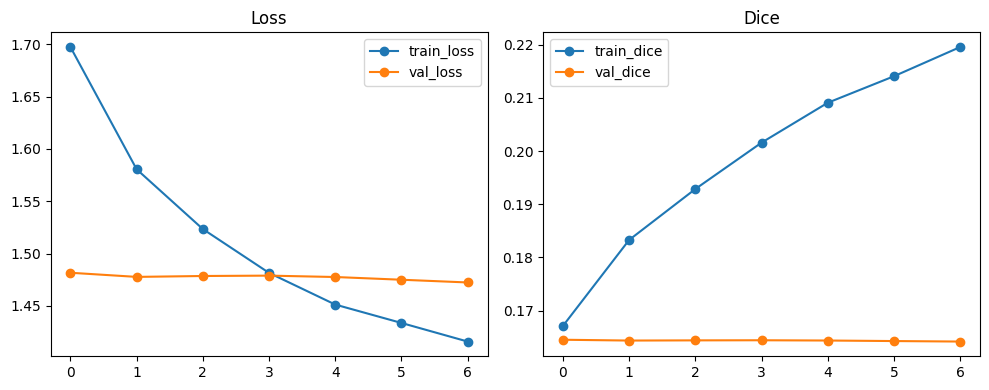

In [ ]:
# Cell 8: Compute test dice (per-sample) and save history plot
import numpy as np
def dice_numpy(y_true, y_pred, thr=0.5, smooth=1e-6):
    y_pred_bin = (y_pred > thr).astype(np.uint8)
    y_true_f = y_true.flatten()
    y_pred_f = y_pred_bin.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    return (2*inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice_scores = []
for xb, yb in test_ds:
    preds = model.predict(xb)
    for i in range(preds.shape[0]):
        dice_scores.append(dice_numpy(yb[i].numpy(), preds[i].squeeze()))
print("Test Dice mean:", np.mean(dice_scores), "std:", np.std(dice_scores))

# Save training history plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], '-o', label='train_loss')
plt.plot(history.history['val_loss'], '-o', label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], '-o', label='train_dice')
plt.plot(history.history['val_dice_coef'], '-o', label='val_dice')
plt.legend(); plt.title('Dice')
plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=200)
print("Saved /content/training_history.png")
plt.show()


In [ ]:
# Cell 9: Zip artifacts and download to local machine
!zip -r /content/brats_results.zip /content/unet_final.h5 /content/unet_best.h5 /content/training_history.png || true
from google.colab import files
files.download("/content/brats_results.zip")


  adding: content/unet_final.h5 (deflated 11%)
  adding: content/unet_best.h5 (deflated 11%)
  adding: content/training_history.png (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cell 10: Visualize predicted mask overlay on FLAIR channel and save images
import matplotlib.pyplot as plt, os
os.makedirs("/content/pred_overlays", exist_ok=True)

# choose some test samples (if test arrays exist)
for i in range(min(10, X_test.shape[0])):
    img = X_test[i]   # H,W,4
    true_mask = y_test[i].squeeze()
    pred = model.predict(img[None,...])[0].squeeze()
    pred_bin = (pred > 0.5).astype(np.uint8)
    base = img[..., 3]  # FLAIR channel
    plt.figure(figsize=(6,6))
    plt.imshow(base, cmap='gray')
    plt.imshow(pred_bin, cmap='Reds', alpha=0.4)
    plt.contour(true_mask, colors='g', linewidths=0.5)
    plt.axis('off')
    fname = f"/content/pred_overlays/overlay_{i}.png"
    plt.savefig(fname, bbox_inches='tight', dpi=150)
    plt.close()
print("Saved overlays to /content/pred_overlays")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Saved overlays to /content/pred_overlays
